## Homewood, AL 2020 City Council Election Results and Boundaries

### Sections
- <a href="#join">Read in Input Files and Join</a><br>
- <a href="#shp">Create Ward Boundaries</a><br>
- <a href="#maup">Join with Election Returns</a><br>
- <a href="#exp">Export Cleaned Datasets</a><br>

#### Sources

- [Homewood, AL 2020 Municipal Election Returns, Ward Level PDF](https://irp-cdn.multiscreensite.com/441cb6f7/files/uploaded/2020%20COH%20Official%20Election%20Results.pdf)) 
- [Homewood, AL Voting Wards Screenshots](https://www.cityofhomewood.com/whos-my-councilor)
- [RDH Alabama 2020 Census Block Boundaries](https://redistrictingdatahub.org/dataset/alabama-block-boundaries-2020/)
-[Census Place Boundaries for City of Homewood](https://data.census.gov/map/160XX00US0103076?layer=VT_2022_160_V2_PY_D1&loc=43.3751,-113.1138,z4.0000)

In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

<p><a name="join"></a></p>

### Read in input files

Election returns were transcribed from PDF to machine readable format, and checked for accuracy.

In [2]:
#Election Returns
er = pd.read_csv("./raw-from-source/HOMEWOOD_ER_PROC.csv")
er.head(2)

,UNIQUE_ID,MNCIPAL,WARD,G20MYRNLAN,G20MYRNMCB,G20MYRNMCC,GCTC1NGEE,GCTC1NTHA,GCTC2NALE,GCTC2NNEW,GCTC2NBAY,GCTC2NLEB,GCTC2NLIM,GCTC2NWOL,GCTCN3HAR,GCTC3NSIM,GCTC3NWIL,GCTC3NJON,GCTC3NNAN,GCTC3NQUI,GCTC4NHAI,GCTC4NSMI,GCTC4NBAT,GCTC4NNEL,GCTC5NFOS,GCTC5NHAR,GCTC5NISB
0,HOMEWOOD_CITYCOUNC-W1,Homewood City,1,284,168,273,426,299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOMEWOOD_CITYCOUNC-W2,Homewood City,2,245,384,468,0,0,638,421,316,181,145,447,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
#Alabama 2020 Census blocks
alblocks = gp.read_file("./raw-from-source/al_b_2020_bound/al_b_2020_bound.shp")
# Subset to just Jefferson County, FIP code 081
jeffblocks = alblocks[alblocks['COUNTYFP20'] == '073'][['GEOID20', 'geometry']]
#jeffblocks.to_file("./raw-from-source/jeffblocks.geojson")

In [4]:
len(jeffblocks)

24469

<AxesSubplot:>

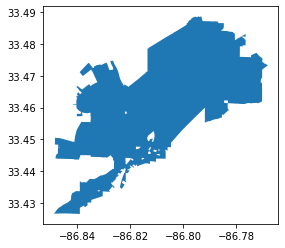

In [5]:
#Census Place Homewood boundaries
shp = gp.read_file("./raw-from-source/tl_2020_01_place/tl_2020_01_place.shp")
homewood = shp[shp['NAME'] == 'Homewood']
homewood.plot()

In [6]:
#Clip Jeff County blocks to Homewood, AL boundaries from Census
clipped = gp.clip(jeffblocks, homewood.geometry)
len(clipped.GEOID20.unique()) # number of unique census blocks
#clipped.to_file("./raw-from-source/homewood_cbp.geojson")

875

<p><a name="shp"></a></p>

### Create Ward Boundaries and Block Assignment File
In QGIS, screenshots of ward boundaries from https://www.cityofhomewood.com/whos-my-councilor were georeferenced. Homewood 2020 Census place blocks were overlaid, and each ward shape was created by selecting
1. Every census block that was wholly contained within ward shape for all 5 wards
2. 43 Additional census blocks that were contained within ward shape, but not contained in 2020 census place.

In [7]:
# Read in shapefiles of all blocks from census place
hw_blocks = gp.read_file("./raw-from-source/homewood_wards.geojson")
# Read in shapefiles for additional blocks
hw_add = gp.read_file("./raw-from-source/add_homewood_blocks.geojson")

In [8]:
# Combine additional blocks
hw_all_blocks = hw_blocks.append(hw_add)

In [9]:
# Create BAF
baf = hw_all_blocks[['GEOID20', 'Ward']]
baf.columns = ['GEOID20', 'WARD']
#Check for duplicates
baf[baf['GEOID20'].duplicated()]

,GEOID20,WARD


Dissolve block shapefile into ward shapes

In [10]:
#dissolve by ward
hw_wards = hw_all_blocks.dissolve(by='Ward').drop('GEOID20', axis = 1).reset_index()
#rename columns
hw_wards.columns = ['WARD', 'geometry']

<AxesSubplot:>

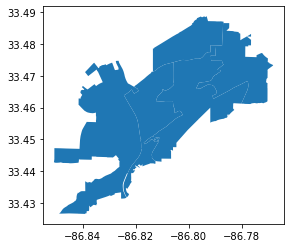

In [11]:
hw_wards.plot()

In [12]:
hw_wards.dtypes

WARD          object
geometry    geometry
dtype: object

### Join with Election Returns

In [13]:
#make sure ward column types are same
er['WARD'] = er['WARD'].astype('int64')
hw_wards['WARD'] = hw_wards['WARD'].astype('int64')

In [14]:
# merge
homewood_pber = er.merge(hw_wards, on='WARD', how = 'right', indicator=True)

In [15]:
#check indicator to see if merge was successful
homewood_pber._merge.value_counts()

both          5
left_only     0
right_only    0
Name: _merge, dtype: int64

In [16]:
#Drop merge column
homewood_pber.drop(labels = ['_merge'], axis = 1, inplace = True)

In [17]:
#Geodf
homewood_pber = gp.GeoDataFrame(homewood_pber, geometry='geometry')
#check
type(homewood_pber)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

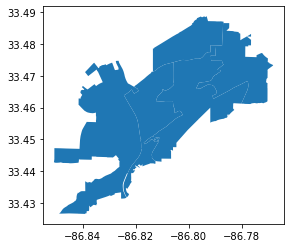

In [18]:
homewood_pber.plot()

In [19]:
homewood_pber.head()

,UNIQUE_ID,MNCIPAL,WARD,G20MYRNLAN,G20MYRNMCB,G20MYRNMCC,GCTC1NGEE,GCTC1NTHA,GCTC2NALE,GCTC2NNEW,GCTC2NBAY,GCTC2NLEB,GCTC2NLIM,GCTC2NWOL,GCTCN3HAR,GCTC3NSIM,GCTC3NWIL,GCTC3NJON,GCTC3NNAN,GCTC3NQUI,GCTC4NHAI,GCTC4NSMI,GCTC4NBAT,GCTC4NNEL,GCTC5NFOS,GCTC5NHAR,GCTC5NISB,geometry
0,HOMEWOOD_CITYCOUNC-W1,Homewood City,1,284,168,273,426,299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-86.78706 33.48411, -86.78710 33.483..."
1,HOMEWOOD_CITYCOUNC-W2,Homewood City,2,245,384,468,0,0,638,421,316,181,145,447,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-86.83750 33.42882, -86.83750 33.428..."
2,HOMEWOOD_CITYCOUNC-W3,Homewood City,3,248,401,635,0,0,0,0,0,0,0,0,306,547,402,710,141,382,0,0,0,0,0,0,0,"POLYGON ((-86.82365 33.43444, -86.82362 33.434..."
3,HOMEWOOD_CITYCOUNC-W4,Homewood City,4,488,310,623,0,0,0,0,0,0,0,0,0,0,0,0,0,0,604,783,556,812,0,0,0,"MULTIPOLYGON (((-86.81247 33.44321, -86.81254 ..."
4,HOMEWOOD_CITYCOUNC-W5,Homewood City,5,329,223,332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,303,490,69,"MULTIPOLYGON (((-86.77861 33.47598, -86.77433 ..."


<p><a name="exp"></a></p>

### Export Cleaned Datasets

In [20]:
if not os.path.exists("./AL20_HOMEWOOD_PBER/AL20_HOMEWOOD_PBER"):
    os.mkdir("./AL20_HOMEWOOD_PBER/AL20_HOMEWOOD_PBER")

homewood_pber.to_file("./AL20_HOMEWOOD_PBER/AL20_HOMEWOOD_PBER/AL20_HOMEWOOD_PBER.shp")
baf.to_csv('./AL20_HOMEWOOD_PBER/AL20_HOMEWOOD_BAF.csv', index=False)

In [21]:
def check_file(path):
    if ".csv" in path:
        file_type = ".csv"
        load = pd.read_csv(path)
    elif ".shp" in path:
        file_type = ".shp"
        load = gp.read_file(path)
        assert(os.path.exists(path[0:-4] + ".cpg"))
        assert(os.path.exists(path[0:-4] + ".dbf"))
        assert(os.path.exists(path[0:-4] + ".prj"))
        assert(os.path.exists(path[0:-4] + ".shx"))
    else:
        raise ValueError ("Other function needed to load non .csv or .shp")
    run_checks(load, path, file_type)
    
def run_checks(file, path, file_type):
    if "/Users" in path:
        path = path.replace("/Users","")
    path_name = path.replace("/","-")
    
        
    with open("./FILE_CHECK" + path_name + ".txt","w") as t:
        t.write("***RDH FILE CHECKER***\n")
        t.write("Checking file located at " + path+"\n")
        t.write("\n")
        t.write("\n")        
        
        t.write("***N/A VALUES***\n")
        if(file.isna().any().sum() != 0):
            t.write("N/A values in the following columns\n")
            for col in file.columns:
                num_nas = file[col].isna().sum()
                string_nans = file[file[col]=="nan"].shape[0]
                if file[col].isna().any().sum():
                    t.write("\t"+col+" - "+ str(num_nas) +" row(s)\n")
                elif  string_nans > 0:
                    t.write("\t"+col+" - "+ str(string_nans) +" row(s)\n")

        else:
            t.write("Do not appear to be N/A values")
        t.write("\n")
        t.write("\n")
        
        t.write("***File Size***\n")
        t.write("File contains " + str(file.shape[0]) + " row(s)\n")
        t.write("File contains " + str(file.shape[1]) + " column(s)\n")
        t.write("\n")
        t.write("\n")
        
        if file_type == ".shp":
            t.write("***Invalid Geometries***\n")
            t.write("File contains " + str(file[~file["geometry"].is_valid].shape[0]) + " invalid GEOM row(s)\n")
            t.write("File contains " + str(file[file["geometry"].is_valid].shape[0]) + " valid GEOM row(s)\n")
            t.write("\n")
            t.write("\n")

        t.write("***COLUMN NAMES***\n")
        t.write(str(list(file.columns)))
        t.write("\n")
        t.write("\n")
        
        t.write("***COLUMN NAME LENGTHS***\n")
        long_col_name_list = [i for i in file.columns if len(i) > 10]
        if len(long_col_name_list) > 0:
            t.write("The following columns are longer than 10 characters:" + str(long_col_name_list)+"\n")
        else:
            t.write("No column names are longer than 10 characters\n")
        t.write("\n")
        t.write("\n")

        t.write("***FULL FILE SUMMARY***\n")
        t.write(str(file.describe())+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***MAX VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.max()) + "\n")
        t.write("\n")
        t.write("\n")

        t.write("***MIN VALUE FOR EVERY DATA COLUMN***\n")
        t.write(str(file.min()) + "\n")
        t.write("\n")
        
        t.write("***NUMERIC COLUMN SUMS***\n")
        t.write(str(file.sum(numeric_only=True))+"\n")
        t.write("\n")
        t.write("\n")

        t.write("***COLUMNS AND DUPLICATE VALUES***\n")
        for col in list(file.columns):
            if col != "geometry":
                if max(file[col].value_counts(dropna = False))==1:
                    t.write("NO: Column " + col + " DOES NOT HAVE duplicate values\n")
                elif max(file[col].value_counts(dropna = False))>1:
                    t.write("YES: Column " + col+ " HAS duplicate values\n")
        t.write("\n")


In [22]:
check_file("./AL20_HOMEWOOD_PBER/AL20_HOMEWOOD_PBER/AL20_HOMEWOOD_PBER.shp")